In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
plt.ion()

In [2]:
# 加载MNIST数据集
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])), batch_size=64, shuffle=True, num_workers=0)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='./data', train=False, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])), batch_size=64, shuffle=True, num_workers=0)

In [3]:
# 空间变换器网络
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
        # 空间变换器定位 - 网络
        self.localization = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )
        # 3 * 2 affine矩阵的回归量
        self.fc_loc = nn.Sequential(
            nn.Linear(10 * 3 * 3, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )
        # 使用身份转换初始化权重/偏差
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))
    
    # 空间变换器网络转发功能
    def stn(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, 10 * 3 * 3)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)
        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)
        return x

    def forward(self, x):
        x = self.stn(x)
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

model = Net().to(device)

In [4]:
# 训练模型
optimizer = optim.SGD(model.parameters(), lr=0.01)

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 500 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset), 
                100. * batch_idx / len(train_loader), loss.item()))

def test():
    with torch.no_grad():
        model.eval()
        test_loss = 0
        correct = 0
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            # 获取最大对数概率的索引
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
        test_loss /= len(test_loader.dataset)
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.320773
Train Epoch: 1 [32000/60000 (53%)]	Loss: 1.014174


c:\users\administrator\appdata\local\programs\python\python36\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.2454, Accuracy: 9304/10000 (93%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.613263
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.278913

Test set: Average loss: 0.1352, Accuracy: 9572/10000 (96%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.370471
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.164791

Test set: Average loss: 0.1168, Accuracy: 9657/10000 (97%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.323522
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.159449

Test set: Average loss: 0.0791, Accuracy: 9755/10000 (98%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.148709
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.204115

Test set: Average loss: 0.0913, Accuracy: 9724/10000 (97%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.184418
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.148479

Test set: Average loss: 0.0618, Accuracy: 9801/10000 (98%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.209653
Train Epoch: 7 [32000/60000 (53%)]	Loss: 0.058636

Test set: Average loss: 0.0604, Accuracy: 9821/10000 (98%)

Tra

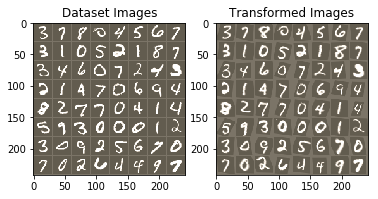

In [5]:
# 可视化STN结果
def convert_image_np(inp):
    """Convert a Tensor to numpy image."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp

def visualize_stn():
    with torch.no_grad():
        # Get a batch of training data
        data = next(iter(test_loader))[0].to(device)
        input_tensor = data.cpu()
        transformed_input_tensor = model.stn(data).cpu()
        in_grid = convert_image_np(torchvision.utils.make_grid(input_tensor))
        out_grid = convert_image_np(torchvision.utils.make_grid(transformed_input_tensor))
        # Plot the results side-by-side
        f, axarr = plt.subplots(1, 2)
        axarr[0].imshow(in_grid)
        axarr[0].set_title('Dataset Images')
        axarr[1].imshow(out_grid)
        axarr[1].set_title('Transformed Images')

for epoch in range(1, 10 + 1):
    train(epoch)
    test()

# 在某些输入批处理上可视化STN转换
visualize_stn()
plt.ioff()
plt.show()